### Adding Emotion and Mouth position columns to the dataframe. Data prep and only for RADIATE data set. Also note Calm, exuberant, and N/A are dropped here to match the virtual dataset for comparing purposes.

In [1]:
import pandas as pd

df = pd.read_csv('datasets/RADIATE_Color_Faces_AU.csv', index_col=0)

df["emotion"] = df.index
df["emotion"] = df["emotion"].str.extract(r'.*_(.*).bmp')
# extract (.)(.) from the emotion column
temp = df["emotion"].str.extract(r'(.)(.)')

df["emotion"] = temp[0]
df["mouth"] = temp[1]

# if emotion is A, then replace A with angry
df["emotion"] = df["emotion"].replace("A", "angry")
# if emotion is C, then replace H with calm
df["emotion"] = df["emotion"].replace("C", "calm")
# if emotion is D, then replace D with disgust
df["emotion"] = df["emotion"].replace("D", "disgust")
# if emotion is F, then replace F with fear
df["emotion"] = df["emotion"].replace("F", "fear")
# if emotion is H, then replace H with happy
df["emotion"] = df["emotion"].replace("H", "happy")
# if emotion is N, then replace N with neutral
df["emotion"] = df["emotion"].replace("N", "neutral")

df = df[df['emotion'] != 'calm']

# if emotion is S, and mouth is U in the same row, then replace S with surprise
df.loc[(df["emotion"] == "S") & (df["mouth"] == "U"), "emotion"] = "surprise"
# if emotion is S, and mouth is not U in the same row, then replace S with sad
df.loc[(df["emotion"] == "S") & (df["mouth"] != "U"), "emotion"] = "sad"

# if mouth is O, then replace O with open
df["mouth"] = df["mouth"].replace("O", "open")
# if mouth is C, then replace C with closed
df["mouth"] = df["mouth"].replace("C", "closed")
# if mouth is U, then replace U with N/A
df["mouth"] = df["mouth"].replace("U", "N/A")
# if mouth is E, then replace E with exuberant
df["mouth"] = df["mouth"].replace("E", "exuberant")

df = df[df['mouth'] != 'exuberant']
df = df[df['mouth'] != 'N/A']

# create an emotionID column
df["emotionID"] = df["emotion"].astype('category').cat.codes

# create a mouthID column
df["mouthID"] = df["mouth"].astype('category').cat.codes

# put the emotion and emotionID columns and mouth and mouthID columns at the beginning of the dataframe
df = df[["emotion", "emotionID", "mouth", "mouthID"] + [col for col in df.columns if col not in ["emotion", "emotionID", "mouth", "mouthID"]]]

# print first 15 rows
print(df.head(15))

             emotion  emotionID   mouth  mouthID      AU01      AU02  \
AF01_AC.bmp    angry          0  closed        0  0.495898  0.146762   
AF01_AO.bmp    angry          0    open        1  0.282826  0.065132   
AF01_DC.bmp  disgust          1  closed        0  0.290751  0.143386   
AF01_DO.bmp  disgust          1    open        1  0.432929  0.075790   
AF01_FC.bmp     fear          2  closed        0  0.713720  0.474423   
AF01_FO.bmp     fear          2    open        1  0.634923  0.563915   
AF01_HC.bmp    happy          3  closed        0  0.566416  0.156642   
AF01_HO.bmp    happy          3    open        1  0.251061  0.258449   
AF01_NC.bmp  neutral          4  closed        0  0.296070  0.181766   
AF01_NO.bmp  neutral          4    open        1  0.249708  0.105011   
AF01_SC.bmp      sad          5  closed        0  0.188280  0.071396   
AF02_AC.bmp    angry          0  closed        0  0.225689  0.134870   
AF02_AO.bmp    angry          0    open        1  0.183468  0.18

### Data prep for UIBVFED Dataset. Only open and closed mouths are considered.

In [2]:
import numpy as np
df2 = pd.read_csv('datasets/UIBVFED_AU.csv', index_col=0)
df2

,AU01,AU02,AU04,AU05,AU06,AU07,AU09,AU10,AU11,AU12,AU14,AU15,AU17,AU20,AU23,AU24,AU25,AU26,AU28,AU43
Jose_CryingClosedMouth.png,0.305842,0.206874,0.446889,0.259702,0.198274,1.0,0.551279,0.841749,0.0,0.088287,0.433585,0.734100,0.692781,0.0,0.613131,0.669285,0.237583,0.072180,0.448243,0.898535
Isabel_SuppressedSadness.png,0.235547,0.246610,0.600681,0.338701,0.135138,0.0,0.100727,0.002648,0.0,0.081693,0.205370,0.219949,0.657510,0.0,0.378242,0.656171,0.004275,0.205725,0.296925,0.043549
Lluis_Sad.png,0.515410,0.348540,0.221837,0.341888,0.214110,0.0,0.140775,0.035123,1.0,0.194547,0.550259,0.456607,0.636465,0.0,0.589314,0.576380,0.308183,0.189351,0.487908,0.037718
Francisca_NearlyCrying.png,0.496980,0.190263,0.405023,0.419461,0.060341,0.0,0.111582,0.020084,0.0,0.017557,0.231320,0.441818,0.588502,0.0,0.667188,0.820854,0.009274,0.110888,0.165012,0.037757
Alicia_CryingClosedMouth.png,0.303942,0.285156,0.330812,0.376726,0.088259,0.0,0.229994,0.024548,0.0,0.042882,0.435663,0.671426,0.654974,0.0,0.660792,0.805387,0.676346,0.282054,0.330363,0.179480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Damia_Neutral.png,0.358094,0.291281,0.163450,0.301980,0.680448,1.0,0.399969,0.956415,1.0,0.826411,0.503110,0.487920,0.747755,1.0,0.754153,0.604370,0.996975,0.473178,0.074434,0.047021
Simona_AbashedSmile.png,0.377999,0.504034,0.287904,0.443344,0.383730,1.0,0.128287,0.276807,0.0,0.537805,0.581881,0.220165,0.645394,1.0,0.584434,0.745784,0.342856,0.059390,0.387240,0.105262
Francisca_Disdain.png,0.560998,0.193603,0.231002,0.334153,0.153729,0.0,0.077741,0.004420,1.0,0.112107,0.349496,0.476254,0.549156,0.0,0.393636,0.627250,0.032408,0.082348,0.172294,0.029646
Tomeu_VeryFrightened.png,0.301362,0.198389,0.300293,0.374935,0.239717,1.0,0.169880,0.053132,0.0,0.245721,0.263867,0.393340,0.647819,0.0,0.416643,0.221148,0.998189,0.704036,0.033983,0.071193


In [3]:
df2["emotion"] = df2.index
df2["emotion"] = df2["emotion"].str.extract(r'_(\w+)\.png')

df2['mouth'] = df2['emotion']
df2['mouth'] = df2['mouth'].replace(['EnragedShouting', 'Terror', 'VeryFrightened', 'FalseLaughter1', 'FalseLaughter2', 'Laughter', 'SmilingOpenMouthed', 'UproariousLaughter', 'CryingOpenMouthed', 'Suprise'], 'open')
df2['mouth'] = np.where(df2['mouth'] != 'open', 'closed', df2['mouth'])

df2["emotion"] = df2["emotion"].replace(['EnragedCompressedLips', 'EnragedShouting', 'Mad', 'SternnessAnger'], "angry") #0
df2["emotion"] = df2["emotion"].replace('Surprise', "surprise") #7
df2["emotion"] = df2["emotion"].replace(['Disdain', 'Disgust', 'PhysicalRepulsion'], 'disgust') #2
df2["emotion"] = df2["emotion"].replace(['Afraid', 'Terror', 'VeryFrightened', 'Worried'], "fear") #3
df2["emotion"] = df2["emotion"].replace(['AbashedSmile', 'DebauchedSmile', 'EagerSmile', 'FalseLaughter1', 'FalseLaughter2',
                                         'FalseSmile', 'IngratiatingSmile', 'Laughter', 'MelancholySmile', 'SlySmile', 'SmilingClosedMouth', 'SmilingOpenMouthed', 'StifledSmile', 'UproariousLaughter'], "happy") #4
df2["emotion"] = df2["emotion"].replace(['CryingClosedMouth', 'CryingOpenMouthed', 'Miserable', 'NearlyCrying', 'Sad', 'SuppressedSadness'], "sad") #6
df2["emotion"] = df2["emotion"].replace('Neutral', 'neutral') #5

df2['emotionID'] = df2['emotion']
df2['mouthID'] = df2['mouth']

# create an emotionID column
df2["emotionID"] = df2["emotion"].astype('category').cat.codes

# create a mouthID column
df2["mouthID"] = df2["mouth"].astype('category').cat.codes

df2 = df2[["emotion", "emotionID", "mouth", "mouthID"] + [col for col in df2.columns if col not in ["emotion", "emotionID", "mouth", "mouthID"]]]

#print(df2[df2.iloc[:, 0].str.contains('sad')])

### Visualize the frequency of emotions in data set. Can change df -> df2 in the code and viceversa to look at each dataset.



emotion
happy       280
sad         120
fear         80
angry        80
disgust      60
neutral      20
surprise     20
Name: count, dtype: int64


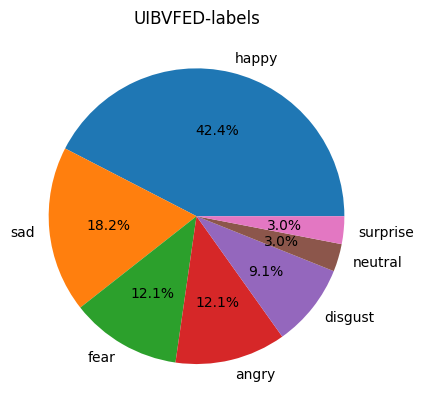

In [4]:
# count the number of occurrences of each emotion in the dataset
emotion_counts = df2["emotion"].value_counts()
print(emotion_counts)

# plot a pie chart of the number of occurrences of each emotion in the dataset
import matplotlib.pyplot as plt
emotion_counts.plot.pie(autopct="%.1f%%")
plt.title("UIBVFED-labels")
plt.ylabel("")
plt.show()

In [5]:
X = df2.drop(columns=["emotion", "emotionID", "mouth"])
y = df2["emotionID"]

In [6]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto')
X_sm, y_sm = smote.fit_resample(X, y)

### Classifier

In this file, we are training a model on the UIBVFED data set and testing accuracies across both.

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.1, random_state=42, stratify=y_sm)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)

In [8]:
print(f'Samples in training set: {X_train.shape[0]} | Samples in the validation set: {X_val.shape[0]} | Samples in the test set: {X_test.shape[0]}')

Samples in training set: 1587 | Samples in the validation set: 177 | Samples in the test set: 196


In [9]:
emotion_counts_test = y_test.value_counts()
print(emotion_counts_test)

emotionID
0    28
1    28
4    28
5    28
6    28
2    28
3    28
Name: count, dtype: int64


In [22]:
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint

input = X.shape[1]
num_classes = len(df2['emotion'].unique())

input_layer = keras.layers.Input(shape=(input,))
model = keras.Sequential([
                input_layer,
                keras.layers.Dense(64, activation = 'relu'),
                # keras.layers.Dropout(0.2),
                keras.layers.Dense(32, activation = 'relu'),
                keras.layers.Dense(num_classes, activation = 'softmax')
])

optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer = optimizer, loss= 'sparse_categorical_crossentropy', metrics= ['accuracy'])

checkpoint = ModelCheckpoint('best_model_UIBVFED.keras', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

model.fit(X_train, y_train, epochs= 100, callbacks=[checkpoint], validation_data=(X_val, y_val))

Epoch 1/100
37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3511 - loss: 1.6452
Epoch 1: val_accuracy improved from -inf to 0.60452, saving model to best_model_UIBVFED.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.3845 - loss: 1.5657 - val_accuracy: 0.6045 - val_loss: 0.9984
Epoch 2/100
43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6663 - loss: 0.8960
Epoch 2: val_accuracy improved from 0.60452 to 0.64407, saving model to best_model_UIBVFED.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6653 - loss: 0.8933 - val_accuracy: 0.6441 - val_loss: 0.8649
Epoch 3/100
48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7220 - loss: 0.7487
Epoch 3: val_accuracy improved from 0.64407 to 0.72316, saving model to best_model_UIBVFED.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7222 - loss: 0.7485 - val_accuracy: 0.7232 - val_loss: 0.7689
Epoch 4/100
35/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7474 - loss: 0.6454
Epoch 4: val_accuracy impr

In [10]:
from tensorflow.keras.models import load_model

best_model = load_model('best_model_UIBVFED.keras')

# Evaluate the best model on the test set
best_model.evaluate(X_test, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9261 - loss: 0.2586  


[0.31293797492980957, 0.9234693646430969]

In [11]:
import numpy as np
y_pred = best_model.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=1)
y_pred_argmax[:5]

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


array([3, 1, 4, 5, 6], dtype=int64)

In [12]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test, y_pred_argmax))

              precision    recall  f1-score   support

           0       0.88      0.82      0.85        28
           1       0.96      0.93      0.95        28
           2       0.93      0.93      0.93        28
           3       0.89      0.89      0.89        28
           4       0.93      1.00      0.97        28
           5       0.86      0.89      0.88        28
           6       1.00      1.00      1.00        28

    accuracy                           0.92       196
   macro avg       0.92      0.92      0.92       196
weighted avg       0.92      0.92      0.92       196



Text(0.5, 1.0, 'ANN on UIBVFED')

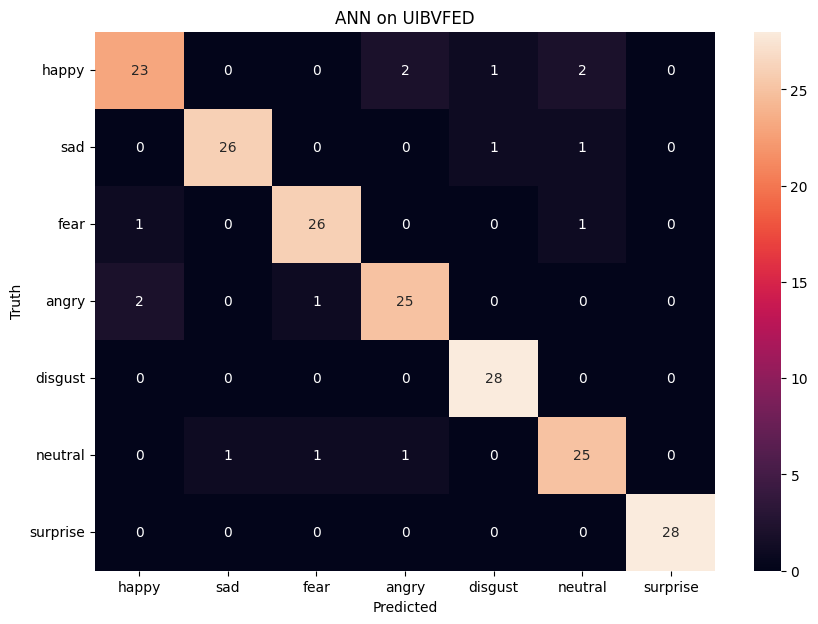

In [13]:
import seaborn as sn
import tensorflow as tf
cm = tf.math.confusion_matrix(labels=y_test,predictions=y_pred_argmax)

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xticks(ticks=[i + 0.5 for i in range(len(emotion_counts))], labels=emotion_counts.index)
plt.yticks(ticks=[i + 0.5 for i in range(len(emotion_counts))], labels=emotion_counts.index, rotation=0)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title("ANN on UIBVFED")

training 4 different models and looking at accuracy of each through heat maps and simple output.

RandomForestClassifier Accuracy: 0.9285714285714286


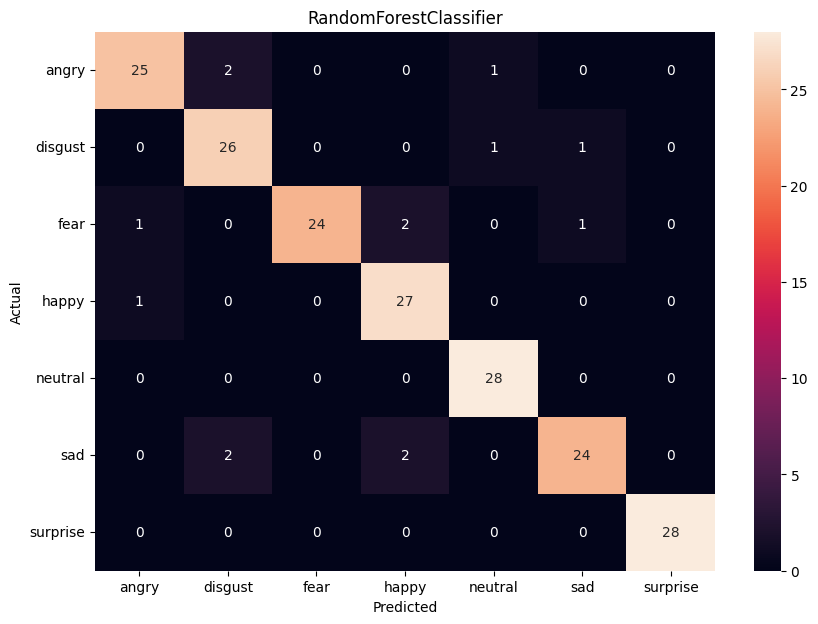

SVC Accuracy: 0.8316326530612245


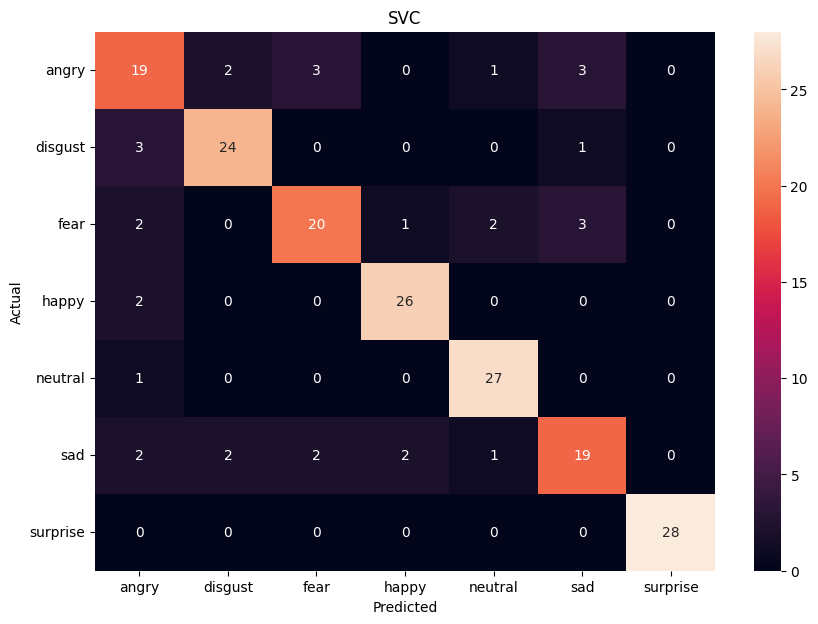

DecisionTreeClassifier Accuracy: 0.7959183673469388


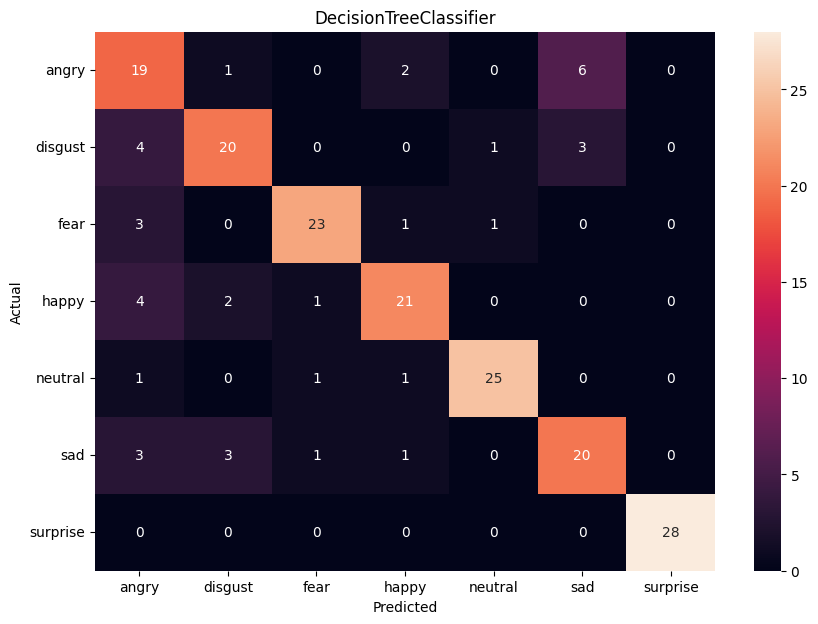

XGBClassifier Accuracy: 0.9183673469387755


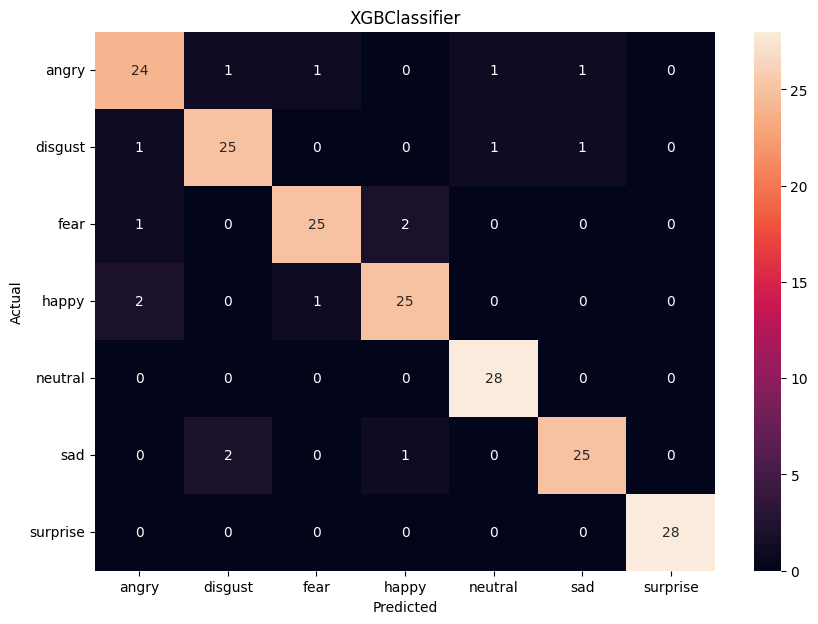

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns


# find the best classifier for the dataset, set the random_state to 42
classifiers = [
    RandomForestClassifier(random_state=12),
    SVC(random_state=12),
    DecisionTreeClassifier(random_state=12),
    XGBClassifier(random_state=12)
]

for clf in classifiers:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, "Accuracy:", accuracy_score(y_test, y_pred))


    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d")
    # put ticks at the center of each cell
    emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
    plt.xticks(ticks=[i + 0.5 for i in range(len(emotion_counts))], labels=emotion_labels)
    plt.yticks(ticks=[i + 0.5 for i in range(len(emotion_counts))], labels=emotion_labels, rotation=0)

    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(clf.__class__.__name__)
    plt.show()

Feature Importance






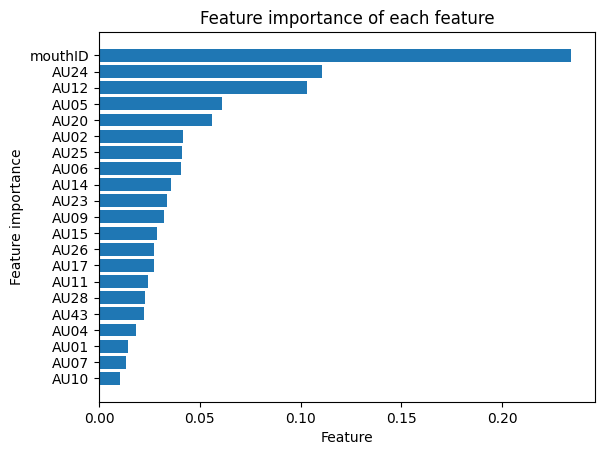

In [24]:
import matplotlib.pyplot as plt

# feature importance
feature_importance = clf.feature_importances_

# plot feature importance
sorted_idx = feature_importance.argsort()
plt.barh(X.columns[sorted_idx], feature_importance[sorted_idx])
plt.xlabel("Feature")
plt.ylabel("Feature importance")
plt.title("Feature importance of each feature")
plt.show()

### Code that tests accuracy of RADIATE dataset on the UIBVFED trained models. Could further visualize data here.


In [25]:
X1 = df.drop(columns=["emotion", "emotionID", "mouth"])
y1 = df["emotionID"]
for clf in classifiers:
  y_pred1 = clf.predict(X1)
  print(clf.__class__.__name__, "Accuracy:", accuracy_score(y1, y_pred1))

RandomForestClassifier Accuracy: 0.4097222222222222
SVC Accuracy: 0.4166666666666667
DecisionTreeClassifier Accuracy: 0.33719135802469136
XGBClassifier Accuracy: 0.3958333333333333


In [26]:
from tensorflow.keras.models import load_model

dl_model = load_model('best_model_UIBVFED.keras')

# Evaluate the best model on the test set
dl_model.evaluate(X1, y1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4052 - loss: 8.2048 


[8.017253875732422, 0.40817901492118835]